## Import Libraries

In [202]:
# Imports
import pandas as pd
import json
import re
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clement_turcan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/clement_turcan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download Unlabelled articles

In [203]:
# Read the json file line by line and append to the dict
raw_json_data = []
with open('./data/20200420_20200714_business_articles.json') as f:
    for line in f:
        raw_json_data.append(json.loads(line))



In [204]:
len(raw_json_data)

416307

## Fetching companies names and related names

In [205]:
# Load companies lexical
companies = pd.read_excel (r'./data/comapny_name-related_words.xlsx', header = None, names=['text'])
# Lower
#df['text'] = [str(row).lower() for index, row in df.iterrows()] 
companies[['companies', "words"]] = companies.text.str.split(";", expand=True)
companies.drop(labels=['text'], axis = 1, inplace=True)
companies = companies.groupby('companies')['words'].apply(list).reset_index(name='lexic')

In [206]:
# Print company name
print(companies.iloc[0][0])
# Print company's list of words
print(print(companies.iloc[0][1]))

21st Century Fox
['Cable television', 'Broadcasting', 'Record label', 'Movie production', 'TV production', 'Rupert Murdoch', 'James Murdoch', 'Lachlan Murdoch', 'Chase Carey', 'Fox Broadcasting Company', '20th Century Fox Television', 'Fox Star Studios', '20th Century Fox', 'Fox Entertainment Group', 'Fox Sports Networks', 'Fox Networks Group', 'Fox Digital Entertainment', 'Sky plc', 'Fox News Channel', 'TrueX', 'National Geographic Channel', '20th Television', 'Blue Sky Studios', 'Fox Television Stations', 'YES Network', 'Endemol Shine Group', 'STAR TV', 'Hulu']
None


In [207]:
companies.head()

,companies,lexic
0,21st Century Fox,"[Cable television, Broadcasting, Record label,..."
1,Activision Blizzard,"[Activision, Call of Duty, Diablo, Heroes of t..."
2,Adobe,"[Adobe, Adobe Systems, John Warnock, Charles G..."
3,Advanced Micro Devices,"[AMD, Processor, graphics, Advanced Micro Devi..."
4,Akamai Technologies,"[Akamai, Tom Leighton, Paul Sagan, George Conr..."


In [208]:
companies.loc[companies.companies=='Akamai Technologies',:].lexic

4    [Akamai, Tom Leighton, Paul Sagan, George Conr...
Name: lexic, dtype: object

In [209]:
print('There are {} different companies.'.format(len(companies.iloc[:])))

There are 52 different companies.


## Extracting url, title & full_text of each article:

In [210]:
urls = []
plain_texts = []
titles = []

min_article_size = 2000
for article in raw_json_data:
    plain_text = article.get('full-text')
    title = article.get('title')
    url = article.get('link')
    if plain_text and ("Article `download()` failed" not in plain_text) and ("Please enable cookies" not in plain_text) and (len(plain_text)>min_article_size):
        plain_texts.append(plain_text)
        urls.append(url)
        titles.append(title)
       

#### Some statistics about removed articles

In [211]:
# total : total number of articles (100%)
# type_1 : percentage  article's length < min_article_size
# type_2 : starts with 'Article `download()` failed'
# type_3 : starts with 'Please enable cookies'

total = len(raw_json_data)
type_1 = round(len([line for line in raw_json_data if len(str(line.get('full-text')))<=min_article_size]) / total * 100, 2)
type_2 = round(len([line for line in raw_json_data if 'Article `download()` failed' in str(line.get('full-text'))]) / total * 100, 2)
type_3 = round(len([line for line in raw_json_data if 'Please enable cookies' in str(line.get('full-text'))]) / total * 100, 2)


In [212]:
perc = {'type_1': type_1, 'type_2': type_2, 'type_3': type_3}

list(perc.keys())[0]

'type_1'

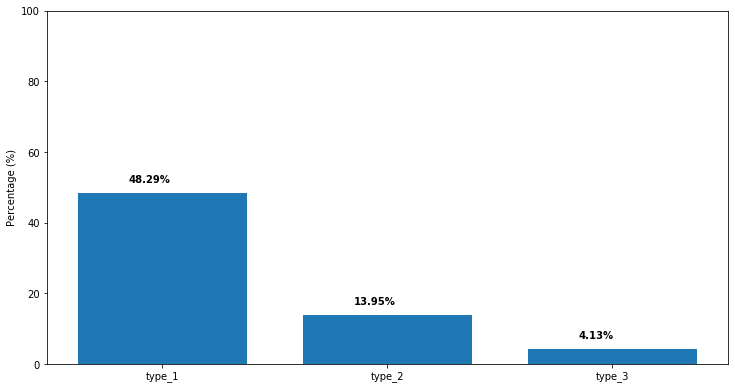

In [257]:
# Plot removed articles
perc = {'type_1': type_1, 'type_2': type_2, 'type_3': type_3}
plt.figure(figsize=(12.2, 6.5))
plt.bar(perc.keys(), perc.values(), width=0.75)
plt.ylim([0,100])
plt.ylabel('Percentage (%)')
for i, v in enumerate(perc.values()):
    plt.text(i - .15, v + 3, str(v) + '%', fontweight='bold')
plt.show()

## Build DataFrame with extracted data

In [214]:
dict_a = {'url': urls, 'title': titles, 'plain_text': plain_texts}
df_articles = pd.DataFrame(dict_a)

In [215]:
df_articles.head()

,url,title,plain_text
0,https://www.dailymail.co.uk/tvshowbiz/article-...,MasterChef's Harry Foster hits back at claims ...,Eliminated MasterChef contestant Harry Foster ...
1,https://www.washingtontimes.com/news/2020/jun/...,"Protest arrests logjam tests NYC legal system,...",NEW YORK (AP) - A wave of arrests in the New Y...
2,https://www.dailymail.co.uk/news/article-83114...,Labour's Anneliese Dodds says she will REFUSE ...,A top shadow minister today said there was not...
3,http://feeds.reuters.com/~r/Reuters/worldNews/...,Civil unrest rages in Minneapolis over raciall...,MINNEAPOLIS (Reuters) - Peaceful rallies gave ...
4,https://www.dailymail.co.uk/news/article-82734...,Australia 'beats the cr*p' out of coronavirus ...,Australia is 'beating the c**p' out of coronav...


## Cleaning the articles

In [216]:
df_cleaned = df_articles.head(5000).copy(deep= True)
df_cleaned['plain_text'] = [re.sub("\n", ' ', re.sub("\r", ' ', text)) for text in df_cleaned['plain_text']]
df_cleaned['plain_text'] = [re.sub(r"\s+", ' ', re.sub("[^a-zA-Z]", ' ', text)) for text in df_cleaned['plain_text']]


In [217]:
len(df_cleaned['plain_text'][1])

4264

#### Finding Stop Words & Removing them from plain text

In [218]:
# Create stopwords list
stopW = stopwords.words('english')
df_cleaned['plain_text_no_sw'] = df_cleaned['plain_text'].apply(lambda words : ' '.join(word for word in words.split() if word not in stopW))


In [219]:
len(df_cleaned['plain_text_no_sw'][1])

3248

In [220]:
df_cleaned.head()

,url,title,plain_text,plain_text_no_sw
0,https://www.dailymail.co.uk/tvshowbiz/article-...,MasterChef's Harry Foster hits back at claims ...,Eliminated MasterChef contestant Harry Foster ...,Eliminated MasterChef contestant Harry Foster ...
1,https://www.washingtontimes.com/news/2020/jun/...,"Protest arrests logjam tests NYC legal system,...",NEW YORK AP A wave of arrests in the New York ...,NEW YORK AP A wave arrests New York City prote...
2,https://www.dailymail.co.uk/news/article-83114...,Labour's Anneliese Dodds says she will REFUSE ...,A top shadow minister today said there was not...,A top shadow minister today said enough eviden...
3,http://feeds.reuters.com/~r/Reuters/worldNews/...,Civil unrest rages in Minneapolis over raciall...,MINNEAPOLIS Reuters Peaceful rallies gave way ...,MINNEAPOLIS Reuters Peaceful rallies gave way ...
4,https://www.dailymail.co.uk/news/article-82734...,Australia 'beats the cr*p' out of coronavirus ...,Australia is beating the c p out of coronaviru...,Australia beating c p coronavirus six states t...


## Labeling articles with company names

In [221]:
def labeling(text, companies):
    labels = []
    for company in companies.companies:
        if company in text:
            labels.append(company)
        else:
            for related_names in companies.loc[companies.companies == company,:].lexic:
                for name in related_names:
                    if name in text and name not in labels:
                        labels.append(company)
                        break
    return labels


In [222]:
de = [labeling(text, companies) for text in df_cleaned['plain_text_no_sw']]

#### Some statistics about companies labeling

In [249]:
# Count occurences of company naming
import operator
comp = {company:0 for company in companies.companies}
for line in de:
    check = any(item in line for item in comp.keys())
    if check is True:
        List = [item for item in line if item in comp.keys()]
        for key in List:
            comp[key] = comp.get(key) + 1
comp = sorted(comp.items(), key=operator.itemgetter(1), reverse=True)

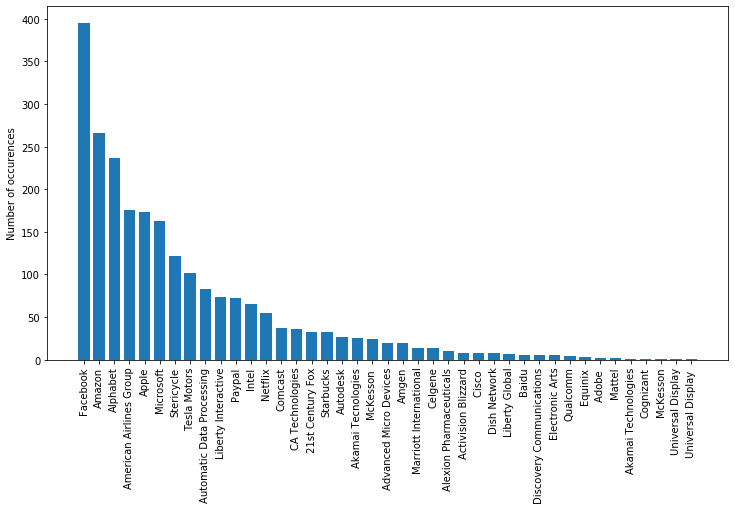

In [259]:
# Plot the statistics
my_dict = {x[0]:x[1] for x in comp if x[1]>0}
dict_null_values = len([x for x in comp if x[1]==0])

plt.figure(figsize=(12.2, 6.5))
plt.bar(my_dict.keys(), my_dict.values(), width=0.75)
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.show()

## Tokenizing the text (to be modified)

In [ ]:
#tokenized_text = []
#for i, article in enumerate(clean_articles):
 #   token_article = word_tokenize(article)
  #  token_article_wo_stopwords = [word for word in token_article if word not in stopW]
   # tokenized_text.append(token_article_wo_stopwords)

In [19]:
tokenized_text

[['eliminated',
  'masterchef',
  'contestant',
  'harry',
  'foster',
  'hit',
  'back',
  'unfair',
  'criticism',
  'judge',
  'melissa',
  'leong',
  'show',
  'first',
  'female',
  'judge',
  'faced',
  'barrage',
  'trolling',
  'haters',
  'taking',
  'aim',
  'everything',
  'behaviour',
  'set',
  'fashion',
  'sense',
  'despite',
  'eliminated',
  'tuesday',
  'night',
  'episode',
  'harry',
  'nothing',
  'good',
  'things',
  'say',
  'melbourne',
  'based',
  'food',
  'writer',
  'could',
  'truth',
  'eliminated',
  'masterchef',
  'australia',
  'contestant',
  'harry',
  'foster',
  'pictured',
  'hit',
  'back',
  'unfair',
  'criticism',
  'judge',
  'melissa',
  'leong',
  'queen',
  'love',
  'harry',
  'told',
  'huffpost',
  'australia',
  'energetic',
  'passionate',
  'really',
  'vibrant',
  'asked',
  'accusations',
  'melissa',
  'rude',
  'biased',
  'show',
  'said',
  'could',
  'truth',
  'three',
  'judges',
  'received',
  'overwhelmingly',
  'posit

In [22]:
# Create the Word2Vec Model
word2vec = Word2Vec(tokenized_text, min_count=2)
sim_words = word2vec.wv.most_similar('australia')
sim_words

[('said', 0.9930940866470337),
 ('new', 0.9927358031272888),
 ('back', 0.9925839900970459),
 ('u', 0.9925734996795654),
 ('government', 0.9925510287284851),
 ('people', 0.9924513697624207),
 ('lockdown', 0.9923855066299438),
 ('year', 0.9923778176307678),
 ('first', 0.9923532009124756),
 ('law', 0.992314338684082)]

In [24]:
# Build a TfidfVectorizer model
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
  return text

tfidf_vec = TfidfVectorizer(tokenizer=identity_tokenizer ,lowercase=False)
X = tfidf_vec.fit_transform(tokenized_text)

In [36]:
# Print the tfidf values for the first doc (article)
first_article_tfidf = X[0]

# Place tf-idf values in a pandas DataFrame 
df = pd.DataFrame(first_article_tfidf.T.todense(), 
                  index=tfidf_vec.get_feature_names(), 
                  columns=["tfidf"]) 
# Sort the value in ascending order
df = df.sort_values(by=["tfidf"],ascending=False)
# Show top 5 most important words in the article in relation to the corpus
df.head()

,tfidf
melissa,0.416750
masterchef,0.312563
harry,0.260469
judge,0.223788
leong,0.208375
